In [1]:
import pandas as pd
import Levenshtein as lev
from scipy.spatial.distance import pdist, squareform
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import networkx as nx
import gravis as gv

# Note you will need to download muscle into the usr/bin and rename it simply as muscle
import biotite.sequence as seq
import biotite.application.muscle as muscle
import biotite.sequence.graphics as graphics

from scipy.stats import mode

# CDR3 Network Graph

Generate network graph to compare CDR3 heavy chain sequences

In [2]:
os.chdir('../..')

In [3]:
config = pd.read_csv("data/10X_bcr_vdj_example/sc5p_v2_hs_B_1k_b/filtered_contig_annotations.csv")
#config = pd.read_csv("data/10X_bcr_vdj_example/nsclc_tumor/vdj_v1_hs_nsclc_multi_5gex_t_b_vdj_b_filtered_contig_annotations.csv")
config

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,fwr3_nt,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id
0,AAACCTGAGGGCTCTC-1,True,AAACCTGAGGGCTCTC-1_contig_1,True,536,IGH,IGHV4-61,NaN,IGHJ5,IGHM,...,ACCAACTACAACCCCTCCCTCAAGAGTCGAGTCACCATATCAGTAG...,CARGDSSGWRGGNWFDPW,TGTGCGAGAGGGGATAGCAGTGGCTGGCGAGGGGGCAACTGGTTCG...,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,889,14,clonotype612,clonotype612_consensus_1,1
1,AAACCTGAGGGCTCTC-1,True,AAACCTGAGGGCTCTC-1_contig_2,True,650,IGL,IGLV1-40,NaN,IGLJ2,IGLC3,...,GGGGTCCCTGACCGATTCTCTGGCTCCAAGTCTGGCACCTCAGCCT...,CQSYDSSLSDVF,TGCCAGTCCTATGACAGCAGCCTGAGTGACGTGTTC,GGGTKLTVL,GGCGGAGGGACCAAGCTGACCGTCCTAG,5214,60,clonotype612,clonotype612_consensus_2,1
2,AAACCTGGTAAGGATT-1,True,AAACCTGGTAAGGATT-1_contig_1,True,566,IGK,IGKV4-1,NaN,IGKJ2,IGKC,...,GGGGTCCCTGACCGGTTCAGTGGCAGCGGGTCTGGGACAGATTTCA...,CQQYYDTPRTF,TGTCAGCAATACTATGATACTCCCCGTACTTTT,GQGTRLEIK,GGCCAGGGGACCAGGCTGGAGATCAAAC,2099,28,clonotype667,clonotype667_consensus_2,1
3,AAACCTGGTAAGGATT-1,True,AAACCTGGTAAGGATT-1_contig_2,True,565,IGH,IGHV1-2,NaN,IGHJ5,IGHM,...,ACAAACTATGCACAGAAGTTTCAGGGCAGGGTCACCATGACCAGGG...,CAMGYCINNNCYEGWFDPW,TGTGCGATGGGATATTGTATTAATAATAACTGTTACGAGGGGTGGT...,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,1410,20,clonotype667,clonotype667_consensus_1,1
4,AAACCTGGTAATAGCA-1,True,AAACCTGGTAATAGCA-1_contig_1,True,549,IGH,IGHV1-18,IGHD6-13,IGHJ5,IGHM,...,ACAAACTATGCACAGAAGCTCCAGGGCAGAGTCACCATGACCACAG...,CARAKRWGYSSSWCDYW,TGTGCGAGAGCCAAACGTTGGGGGTATAGCAGCAGCTGGTGCGACT...,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,3982,60,clonotype425,clonotype425_consensus_1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,TTTGGTTCATCTCGCT-1,True,TTTGGTTCATCTCGCT-1_contig_2,True,659,IGH,IGHV5-51,NaN,IGHJ4,IGHG1,...,ACCAGATACAGCCCGTCCTTCCAAGGCCAGGTCACCATCTCAGTCG...,CARARRNFGLVIDYW,TGTGCGAGAGCGAGGAGAAATTTTGGGCTGGTTATTGACTACTGG,GQGIQVTVSS,GGCCAGGGAATCCAGGTCACCGTCTCCTCAG,470,13,clonotype274,clonotype274_consensus_1,1
2258,TTTGGTTCATTAGGCT-1,True,TTTGGTTCATTAGGCT-1_contig_1,True,645,IGL,IGLV1-47,NaN,IGLJ3,IGLC2,...,GGGGTCCCTGAGCGATTCTCTGGCTCCAAGTCTGGCACCTCAGCCT...,CAVWDDSLSGRVF,TGTGCTGTATGGGATGACAGCCTGAGTGGCAGGGTGTTC,GGGTKLTVL,GGCGGAGGGACCAAGCTCACCGTCCTAG,2142,34,clonotype89,clonotype89_consensus_2,1
2259,TTTGGTTCATTAGGCT-1,True,TTTGGTTCATTAGGCT-1_contig_2,True,670,IGH,IGHV3-7,NaN,IGHJ4,IGHG1,...,AGATACTATGTGGGCTCTGTGAAGGGCCGATTCACCATCTCCAGAG...,CARDEVAGREFW,TGTGCGAGAGACGAAGTGGCGGGAAGAGAGTTTTGG,GQGTLVAVSS,GGCCAGGGAACGTTGGTCGCCGTCTCCTCGG,191,10,clonotype89,clonotype89_consensus_1,1
2260,TTTGTCAAGTGTTTGC-1,True,TTTGTCAAGTGTTTGC-1_contig_1,True,566,IGH,IGHV1-8,IGHD3-22,IGHJ3,IGHM,...,ACAGGCTATGCACAGAAGTTCCAGGGCAGAGTCACCATGACCAGGA...,CARKNYYDSSGYYPDAFDIW,TGTGCGAGGAAGAATTACTATGATAGTAGTGGTTATTACCCCGATG...,GQGTMVTVSS,GGCCAAGGGACAATGGTCACCGTCTCTTCAG,1291,24,clonotype744,clonotype744_consensus_1,1


## EDA

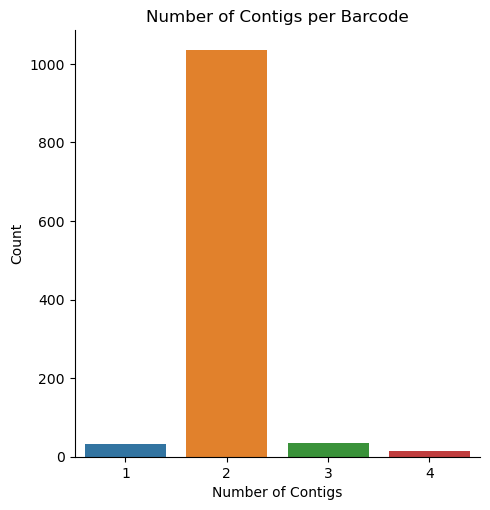

In [4]:
barcode_counts = config.groupby("barcode").count()[["is_cell"]].reset_index()

num_of_contigs_per_barcode = barcode_counts.groupby("is_cell").count().reset_index()
num_of_contigs_per_barcode = num_of_contigs_per_barcode.rename(columns={"is_cell":"num_contigs", "barcode":"count"})

sns.catplot(data=num_of_contigs_per_barcode,
           x="num_contigs", y="count",
           kind="bar").set(title="Number of Contigs per Barcode", 
                           xlabel="Number of Contigs",
                           ylabel="Count");

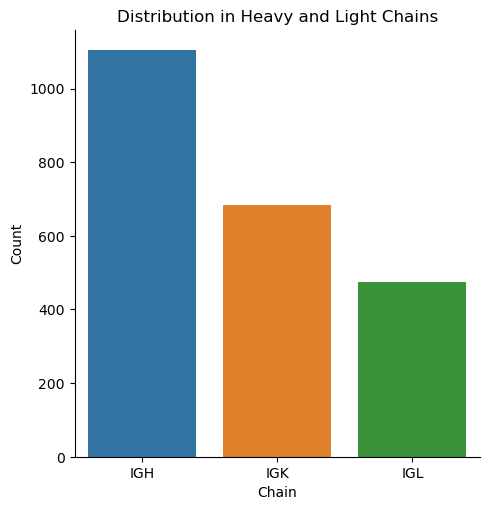

In [5]:
chain_counts = config.groupby("chain").count()[["barcode"]].reset_index().rename(columns={"barcode":"count"})

sns.catplot(data=chain_counts,
           x="chain", y="count",
           kind="bar").set(title="Distribution in Heavy and Light Chains",
                          xlabel="Chain", ylabel="Count");

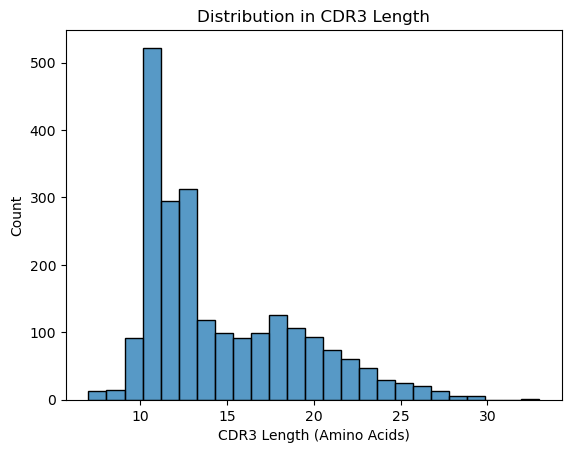

In [6]:
config['cdr3_len'] = config['cdr3'].apply(len)

sns.histplot(data=config,
           x="cdr3_len").set(title="Distribution in CDR3 Length",
                            xlabel="CDR3 Length (Amino Acids)",
                            ylabel="Count");

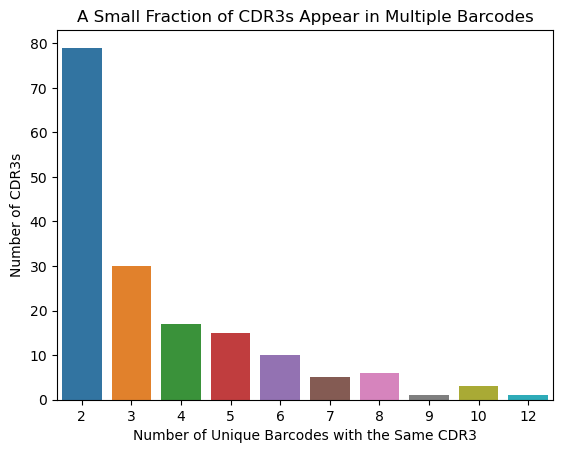

In [7]:
duplicated_cdr3 = config.groupby(["cdr3", "barcode"]).count()[["is_cell"]]
duplicated_cdr3 = duplicated_cdr3.groupby("cdr3").count().reset_index().rename(columns={"is_cell": "count"})
duplicated_cdr3 = duplicated_cdr3[duplicated_cdr3["count"] != 1]
 
sns.countplot(data=duplicated_cdr3, x="count").set(title="A Small Fraction of CDR3s Appear in Multiple Barcodes",
                                                  xlabel="Number of Unique Barcodes with the Same CDR3",
                                                  ylabel="Number of CDR3s");

# QC

In [8]:
# Filter contigs

# 10X does not recommend removing barcodes/cells with three or four chains

# Keep only the CDR3 heavy chain sequences
cdr3_h = config[config["chain"] == "IGH"].reset_index(drop=True)
cdr3_h

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id,cdr3_len
0,AAACCTGAGGGCTCTC-1,True,AAACCTGAGGGCTCTC-1_contig_1,True,536,IGH,IGHV4-61,NaN,IGHJ5,IGHM,...,CARGDSSGWRGGNWFDPW,TGTGCGAGAGGGGATAGCAGTGGCTGGCGAGGGGGCAACTGGTTCG...,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,889,14,clonotype612,clonotype612_consensus_1,1,18
1,AAACCTGGTAAGGATT-1,True,AAACCTGGTAAGGATT-1_contig_2,True,565,IGH,IGHV1-2,NaN,IGHJ5,IGHM,...,CAMGYCINNNCYEGWFDPW,TGTGCGATGGGATATTGTATTAATAATAACTGTTACGAGGGGTGGT...,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,1410,20,clonotype667,clonotype667_consensus_1,1,19
2,AAACCTGGTAATAGCA-1,True,AAACCTGGTAATAGCA-1_contig_1,True,549,IGH,IGHV1-18,IGHD6-13,IGHJ5,IGHM,...,CARAKRWGYSSSWCDYW,TGTGCGAGAGCCAAACGTTGGGGGTATAGCAGCAGCTGGTGCGACT...,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,3982,60,clonotype425,clonotype425_consensus_1,1,17
3,AAACCTGGTACGCACC-1,True,AAACCTGGTACGCACC-1_contig_1,True,535,IGH,IGHV7-4-1,NaN,IGHJ4,IGHM,...,CARALGAIELFDYW,TGTGCGAGAGCCCTGGGGGCTATTGAACTCTTTGATTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,3554,61,clonotype195,clonotype195_consensus_1,1,14
4,AAACCTGTCCAACCAA-1,True,AAACCTGTCCAACCAA-1_contig_2,True,572,IGH,IGHV3-15,NaN,IGHJ4,IGHM,...,CTTDEGDGYSFDYW,TGTACCACAGATGAGGGGGATGGCTACTCCTTTGACTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,1275,19,clonotype137,clonotype137_consensus_2,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,TTTATGCTCATAAAGG-1,True,TTTATGCTCATAAAGG-1_contig_1,True,517,IGH,IGHV4-59,NaN,IGHJ4,IGHM,...,CARGDFPVIFDYW,TGTGCGAGAGGTGACTTCCCGGTCATATTTGACTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,618,8,clonotype88,clonotype88_consensus_1,1,13
1100,TTTGCGCTCTGAAAGA-1,True,TTTGCGCTCTGAAAGA-1_contig_2,True,642,IGH,IGHV3-33,IGHD2-2,IGHJ6,IGHG3,...,CARSYIVVVPAAIGYYGMDVW,TGTGCGCGATCCTATATTGTAGTAGTACCAGCTGCTATTGGCTACT...,GQGTTVTVSS,GGCCAAGGGACCACGGTCACCGTCTCCTCAG,1500,49,clonotype767,clonotype767_consensus_1,1,21
1101,TTTGGTTCATCTCGCT-1,True,TTTGGTTCATCTCGCT-1_contig_2,True,659,IGH,IGHV5-51,NaN,IGHJ4,IGHG1,...,CARARRNFGLVIDYW,TGTGCGAGAGCGAGGAGAAATTTTGGGCTGGTTATTGACTACTGG,GQGIQVTVSS,GGCCAGGGAATCCAGGTCACCGTCTCCTCAG,470,13,clonotype274,clonotype274_consensus_1,1,15
1102,TTTGGTTCATTAGGCT-1,True,TTTGGTTCATTAGGCT-1_contig_2,True,670,IGH,IGHV3-7,NaN,IGHJ4,IGHG1,...,CARDEVAGREFW,TGTGCGAGAGACGAAGTGGCGGGAAGAGAGTTTTGG,GQGTLVAVSS,GGCCAGGGAACGTTGGTCGCCGTCTCCTCGG,191,10,clonotype89,clonotype89_consensus_1,1,12


# Generate Distance Matrix

In [9]:
# List of CDR3 aa sequences
cdr3_sequences = list(cdr3_h["cdr3"])
cdr3_len = len(cdr3_sequences)

# Prepare 2 dimensional array M x N (M entries (len cdr3_sequences) with N dimensions (1)) 
transformed_strings = np.array(cdr3_sequences).reshape(-1,1)

# Calculate distance matrix using the Levenshtein distance function
distance_matrix = pdist(transformed_strings, lambda x,y: lev.distance(x[0],y[0]))

# Square distance matrix
cdr3_matrix = squareform(distance_matrix).astype(np.int64)

cdr3_matrix

array([[ 0, 11, 11, ..., 12, 11, 11],
       [11,  0, 14, ..., 14, 14, 13],
       [11, 14,  0, ...,  9, 12, 13],
       ...,
       [12, 14,  9, ...,  0, 10, 14],
       [11, 14, 12, ..., 10,  0, 14],
       [11, 13, 13, ..., 14, 14,  0]])

Matrix traversal:
https://people.revoledu.com/kardi/tutorial/VB/tips/Symmetric-Matrix.html

In [10]:
# Take the upper right triangular matrix w/out diagnonal
distance_distribution = []

for row in np.arange(1, cdr3_len-1):
    for col in np.arange(row+1, cdr3_len):
        distance_distribution += [cdr3_matrix[row, col]]

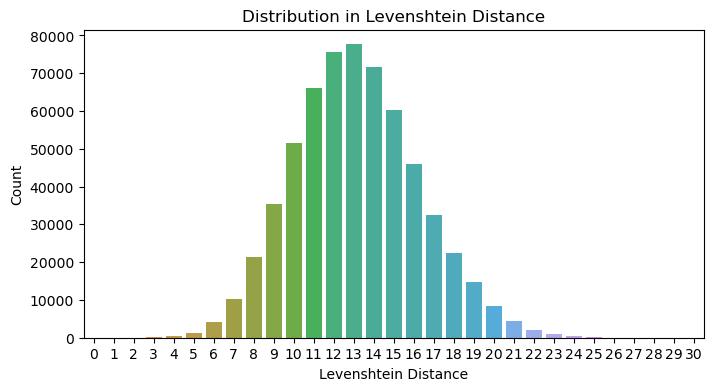

In [11]:
plt.figure(figsize=(8,4))

distance_matrix_df = pd.DataFrame({"dist": distance_distribution})

sns.countplot(data=distance_matrix_df,
            x="dist").set(title="Distribution in Levenshtein Distance",
                         xlabel="Levenshtein Distance",
                         ylabel="Count");

In [12]:
mean = np.mean(distance_distribution)
sd = np.std(distance_distribution)
print("Mean: ", mean)
print("SD: ", sd)

Mean:  13.119388962292247
SD:  3.1320376654785793


# Plot Network

Code on how to modify graph display: https://robert-haas.github.io/gravis-docs/code/examples/external_tools/networkx.html

In [13]:
# Identify the cutoff point on whether there should be an edge between two nodes 
# Based on https://www.frontiersin.org/articles/10.3389/fimmu.2018.00224/full#h3, 
# the standard is one amino acid difference
cutoff_point = 3

# Generate binary distance matrix
boolean_filter = cdr3_matrix <= cutoff_point
boolean_filter = boolean_filter.astype(int)

G = nx.Graph()

# Add the nodes
G.add_nodes_from(np.arange(cdr3_len))

# Add the edges
# Take the upper right triangular matrix w/out diagnonal
for row in np.arange(1, cdr3_len-1):
    for col in np.arange(row+1, cdr3_len):
        if boolean_filter[row, col] == 1:
            G.add_weighted_edges_from([(row, col, 1)])

# Set node weights based on number of edges
#node_degree = [G.degree(x) for x in np.arange(len(cdr3_sequences))]
#for i in np.arange(len(cdr3_sequences)):
#    G.nodes[i]['size'] = node_degree[i]

# Node degree - number of edges per node
# Calculate this before removing the nodes with no edges
degree_sequence = [d for n, d in G.degree()]

# Remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))
            
gv.d3(G, edge_size_data_source='weight', use_node_size_normalization=True)

In [14]:
# Extracts out the relevant subnetworks

# The min number of nodes in a subgraph for futher analysis
network_num_nodes_cutoff = 5

# Provides a set of nodes in a list that are all connected with each other
sub_networks = sorted(nx.connected_components(G), key=len, reverse=True)

filtered_sub_networks = []

for sub_network in sub_networks:
    if len(sub_network) >= network_num_nodes_cutoff:
        filtered_sub_networks += [list(sub_network)]

filtered_sub_networks

[[131,
  644,
  648,
  780,
  1037,
  1040,
  533,
  151,
  156,
  422,
  296,
  168,
  685,
  560,
  57,
  327,
  199,
  204,
  981,
  240,
  242,
  626,
  509],
 [34, 623, 952, 89, 410],
 [485, 874, 465, 818, 497]]

# Network Analysis

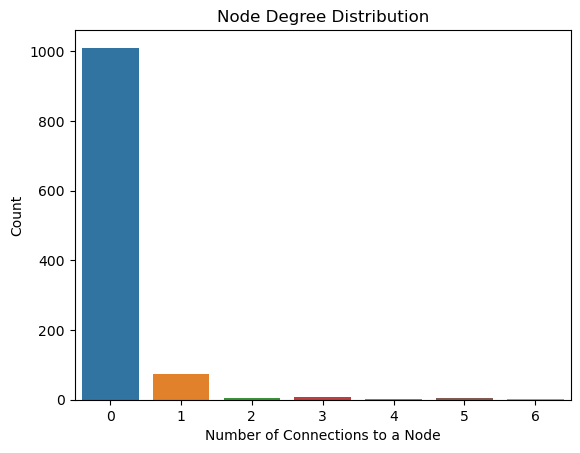

In [15]:
sns.countplot(data=pd.DataFrame({"node_degree": degree_sequence}),
             x="node_degree").set(title="Node Degree Distribution",
                         xlabel="Number of Connections to a Node",
                         ylabel="Count");

In [16]:
# Node clustering coefficient - a measure of the degree to which nodes in a graph tend to cluster together
# This is 1 for fully connected graphs and 0 for hardly any connections

#print("Clustering Coefficent for Nodes: ", nx.clustering(G, 0))

# Consensus Sequence Analysis

In [17]:
largest_network = filtered_sub_networks[0]

cdr3_h_largest_network = cdr3_h.iloc[largest_network, :]

cdr3_h_largest_network

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id,cdr3_len
131,AGCAGCCAGACGACGT-1,True,AGCAGCCAGACGACGT-1_contig_3,True,508,IGH,IGHV2-26,IGHD5-12,IGHJ4,IGHM,...,CARSYSGYDYDYW,TGTGCACGGTCATATAGTGGCTACGATTACGACTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,2488,38,clonotype177,clonotype177_consensus_1,1,13
644,GATTCAGAGCGCTTAT-1,True,GATTCAGAGCGCTTAT-1_contig_2,True,522,IGH,IGHV4-39,NaN,IGHJ4,IGHM,...,CARRLVYFDYW,TGTGCGAGACGGTTGGTTTACTTTGACTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,2849,54,clonotype652,clonotype652_consensus_1,1,11
648,GCAATCAAGTCAATAG-1,True,GCAATCAAGTCAATAG-1_contig_2,True,553,IGH,IGHV3-23,NaN,IGHJ4,IGHM,...,CAKDIRGDYW,TGTGCGAAGGACATCCGGGGGGACTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,3215,50,clonotype50,clonotype50_consensus_1,1,10
780,GGTATTGTCAACGCTA-1,True,GGTATTGTCAACGCTA-1_contig_2,True,560,IGH,IGHV3-64,NaN,IGHJ4,IGHM,...,CARSSGGWYDYW,TGTGCGAGGAGCAGCGGTGGCTGGTATGACTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,2413,35,clonotype113,clonotype113_consensus_1,1,12
1037,TGCTGCTTCTGGGCCA-1,True,TGCTGCTTCTGGGCCA-1_contig_2,True,535,IGH,IGHV1-69D,NaN,IGHJ4,IGHM,...,CARSGSHFDYW,TGTGCGAGGAGTGGGAGTCACTTTGACTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,2684,44,clonotype70,clonotype70_consensus_1,1,11
1040,TGGACGCCAACAACCT-1,True,TGGACGCCAACAACCT-1_contig_2,True,565,IGH,IGHV3-7,NaN,IGHJ4,IGHM,...,CARLYSGYDADDYW,TGTGCGAGACTATATAGTGGCTACGATGCGGATGACTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,2285,39,clonotype212,clonotype212_consensus_1,1,14
533,CTCGTACCAGGACCCT-1,True,CTCGTACCAGGACCCT-1_contig_1,True,556,IGH,IGHV3-7,NaN,IGHJ4,IGHM,...,CARDLRIFDYW,TGTGCGAGAGATCTACGGATCTTTGACTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,1617,31,clonotype56,clonotype56_consensus_1,1,11
151,AGCTCTCCAAGCCATT-1,True,AGCTCTCCAAGCCATT-1_contig_1,True,539,IGH,IGHV1-8,NaN,IGHJ4,IGHM,...,CARESGYPDYW,TGTGCGAGAGAAAGTGGTTATCCTGACTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,4645,75,clonotype62,clonotype62_consensus_1,1,11
156,AGCTCTCTCGGTTCGG-1,True,AGCTCTCTCGGTTCGG-1_contig_1,True,532,IGH,IGHV1-69D,NaN,IGHJ4,IGHM,...,CARNYYFDYW,TGTGCGAGGAATTACTACTTTGACTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,3097,51,clonotype49,clonotype49_consensus_1,1,10
422,CGATGGCCAGTTTACG-1,True,CGATGGCCAGTTTACG-1_contig_1,True,534,IGH,IGHV1-8,NaN,IGHJ4,IGHM,...,CARGHFNYW,TGTGCGAGAGGCCATTTTAATTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,3041,48,clonotype37,clonotype37_consensus_1,1,9


In [18]:
# Align the CDR3 sequences within the largest network using the MUSCLE alignment tool
seq_to_align = []
for cdr3 in cdr3_h_largest_network['cdr3']:
    seq_to_align += [seq.ProteinSequence(cdr3)]
    
app = muscle.Muscle5App(seq_to_align)
app.start()
app.join()
alignment = app.get_alignment()

# Needs to be exported as a text file to be manipulated further
with open("data/10X_bcr_vdj_example/sc5p_v2_hs_B_1k_b/largest_network_alignment.txt", "a") as f:
  print(alignment, file=f)

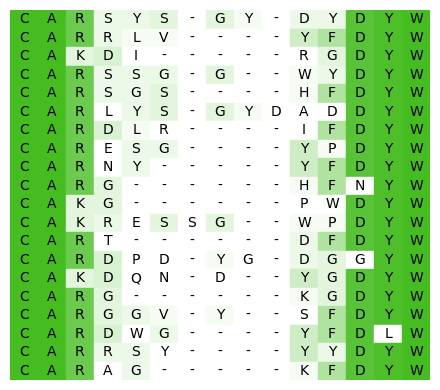

In [19]:
fig = plt.figure(figsize=(4.5, 4.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax, alignment[:,:20], symbols_per_line=len(alignment)
)
ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontstyle":"italic"})
fig.tight_layout()

In [20]:
# Convert the aligned sequences into a matrix
aligned_sequences = list(pd.read_csv("data/10X_bcr_vdj_example/sc5p_v2_hs_B_1k_b/largest_network_alignment.txt", header=None).iloc[:, 0])

aligned_sequences_matrix = []
for aligned_cdr3 in aligned_sequences:
    aligned_sequences_matrix += [[*aligned_cdr3]]

aligned_sequences_matrix = np.array(aligned_sequences_matrix)
aligned_sequences_matrix

array([['C', 'A', 'R', ..., 'D', 'Y', 'W'],
       ['C', 'A', 'R', ..., 'D', 'Y', 'W'],
       ['C', 'A', 'K', ..., 'D', 'Y', 'W'],
       ...,
       ['C', 'A', 'R', ..., 'D', 'Y', 'W'],
       ['C', 'A', 'R', ..., 'D', 'L', 'W'],
       ['C', 'A', 'R', ..., 'D', 'Y', 'W']], dtype='<U1')

In [21]:
# Get the most common amino acid in each position
aligned_sequence_most_frequent_char = mode(aligned_sequences_matrix, axis=0).mode[0]
aligned_sequence_most_frequent_char

array(['C', 'A', 'R', 'D', '-', '-', '-', '-', '-', '-', 'Y', 'F', 'D',
       'Y', 'W'], dtype='<U1')

In [22]:
# Remove the gaps and generate the consensus sequence
consensus_seq = "".join([amino_acid for amino_acid in aligned_sequence_most_frequent_char if amino_acid != "-"])
consensus_seq

'CARDYFDYW'

In [23]:
# Generate Levenshtein distance between CDR3 and consensus sequence
cdr3_h_largest_network['lev_consensus'] = cdr3_h_largest_network["cdr3"].apply(lambda x: lev.distance(x, consensus_seq))

cdr3_h_largest_network[['barcode', 'cdr3', 'lev_consensus']].sort_values('lev_consensus').head(7)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,barcode,cdr3,lev_consensus
509,CTAGAGTCAAACGTGG-1,CARDDYGDYW,2
685,GCGCAACTCAAACGGG-1,CARTDFDYW,2
156,AGCTCTCTCGGTTCGG-1,CARNYYFDYW,2
327,CATATTCGTCCTGCTT-1,CARGKGDYW,3
626,GATCGATGTTGGTGGA-1,CARDSGYFDLW,3
204,ATCACGAGTGTGAAAT-1,CARDWGYFDLW,3
422,CGATGGCCAGTTTACG-1,CARGHFNYW,3


In [28]:
# Select only the cells with a minimum Levenshtein distance number
cells_of_interest_idx = cdr3_h_largest_network[cdr3_h_largest_network['lev_consensus'] == 2].index

cdr3_h.iloc[cells_of_interest_idx, :]

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id,cdr3_len
156,AGCTCTCTCGGTTCGG-1,True,AGCTCTCTCGGTTCGG-1_contig_1,True,532,IGH,IGHV1-69D,NaN,IGHJ4,IGHM,...,CARNYYFDYW,TGTGCGAGGAATTACTACTTTGACTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,3097,51,clonotype49,clonotype49_consensus_1,1,10
685,GCGCAACTCAAACGGG-1,True,GCGCAACTCAAACGGG-1_contig_2,True,530,IGH,IGHV5-51,NaN,IGHJ4,IGHM,...,CARTDFDYW,TGTGCGAGGACTGACTTTGACTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,6625,88,clonotype40,clonotype40_consensus_1,1,9
509,CTAGAGTCAAACGTGG-1,True,CTAGAGTCAAACGTGG-1_contig_2,True,533,IGH,IGHV1-18,NaN,IGHJ4,IGHM,...,CARDDYGDYW,TGTGCGAGAGACGACTACGGGGACTACTGG,GQGTLVTVSS,GGCCAGGGAACCCTGGTCACCGTCTCCTCAG,3977,55,clonotype53,clonotype53_consensus_1,1,10
